# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

/var/folders/0c/r0htcd1j05v_lb53s4xtzbn80000gn/T/ipykernel_39718/3018219347.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("../data/train.csv")


# 1️⃣ Datenbereinigung - train

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

## Identifikatoren - ID, Customer_ID, Name, SSN
- Entfernt überflüssige Leerzeichen in den ID-Spalten
- Vereinheitlicht Namen und setzt fehlende Werte auf Unknown
- Maskiert ungültige SSN-Einträge

In [4]:
train_df['ID'] = train_df['ID'].astype(str).str.strip()
train_df['Customer_ID'] = train_df['Customer_ID'].astype(str).str.strip()

In [5]:
train_df['Name'] = (
    train_df['Name']
    .fillna('Unknown')
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.title()
)

In [6]:
pattern = re.compile(r'^\d{3}-\d{2}-\d{4}$')

train_df['SSN'] = (
    train_df['SSN']
    .astype(str)
    .str.strip()
    .where(lambda s: s.apply(lambda x: bool(pattern.match(x)) if isinstance(x, str) else False), other=pd.NA)
)

In [7]:
train_df[['ID', 'Customer_ID', 'Name', 'SSN']].head()

,ID,Customer_ID,Name,SSN
0,0x1602,CUS_0xd40,Aaron Maashoh,821-00-0265
1,0x1603,CUS_0xd40,Aaron Maashoh,821-00-0265
2,0x1604,CUS_0xd40,Aaron Maashoh,821-00-0265
3,0x1605,CUS_0xd40,Aaron Maashoh,821-00-0265
4,0x1606,CUS_0xd40,Aaron Maashoh,821-00-0265


## Month - Represents the month of the year

- Zu welchen Monat die Daten zu der ID gehören
- Eine ID (Kunde) enthählt 3 Einträge zu seinem Konto und hat somit 3 Monate (Bsp. Mai bis Juli)

In [8]:
train_df["Month"].isna().sum()

0

In [9]:
train_df['Month'] = (
    train_df['Month']
    .astype(str)
    .str.strip()
    .str.title()
)

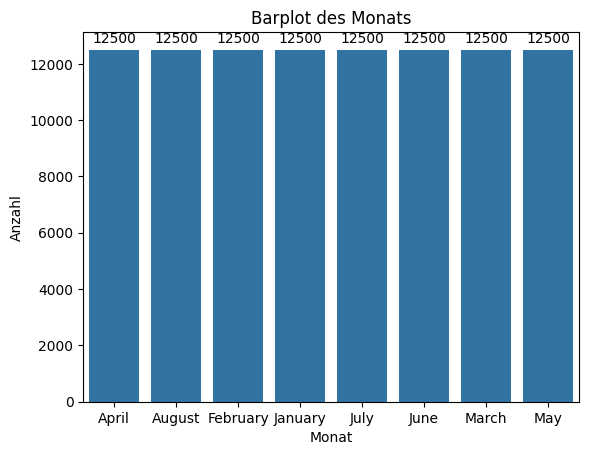

In [10]:
month_counts = train_df['Month'].value_counts().sort_index()
ax = sns.barplot(
    x=month_counts.index.astype(str),
    y=month_counts.values
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Barplot des Monats')
plt.xlabel('Monat')
plt.ylabel('Anzahl')
plt.show()


- man hat nur Daten von Januar bis August
- was ist mit Septemeber bis Dezember?

## Age - Represents the age of the person

In [11]:
train_df["Age"].isna().sum()

0

In [12]:
train_df['Age'] = (
    train_df['Age']
    .astype(str)
    .str.replace('_', '', regex=False)
)

In [13]:
train_df['Age'] = pd.to_numeric(train_df['Age'], errors='coerce').abs()

In [14]:
mask = train_df['Age'] >= 100
train_df.loc[mask, 'Age'] = (
    train_df.loc[mask, 'Age'].astype(str).str[:2].astype(float)
)

mask = train_df['Age'] >= 100
train_df.loc[mask, 'Age'] = (
    train_df.loc[mask, 'Age'].astype(str).str[:1].astype(float)
)

In [15]:
train_df['Age'] = (
    train_df['Age']
    .clip(lower=18, upper=90)
    .fillna(train_df['Age'].median())
    .round()
    .astype('Int64')
)

In [16]:
train_df['Age'].describe()

count     100000.0
mean      33.90617
std      11.147451
min           18.0
25%           25.0
50%           33.0
75%           42.0
max           90.0
Name: Age, dtype: Float64

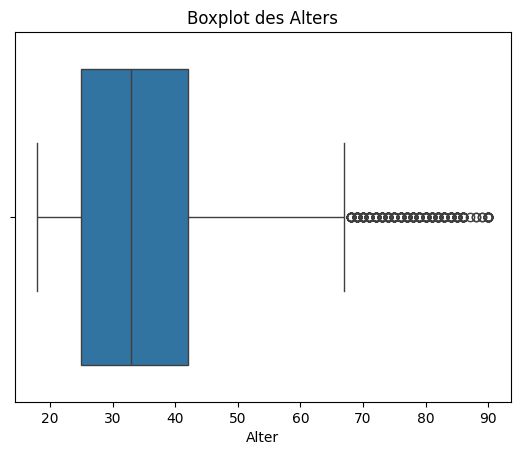

In [17]:
sns.boxplot(data=train_df, x="Age")
plt.title("Boxplot des Alters")
plt.xlabel("Alter")
plt.show()

## Occupation - Represents the Occupation of the person (Beruf)

In [18]:
train_df["Occupation"].isna().sum()

0

In [19]:
train_df['Occupation'] = (
    train_df['Occupation']
    .astype(str)
    .replace('_______', 'Unknown')
    .str.replace('_', ' ', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .str.title()
)

In [20]:
train_df['Occupation'].value_counts().head(10)

Occupation
Unknown          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media Manager    6232
Teacher          6215
Name: count, dtype: int64

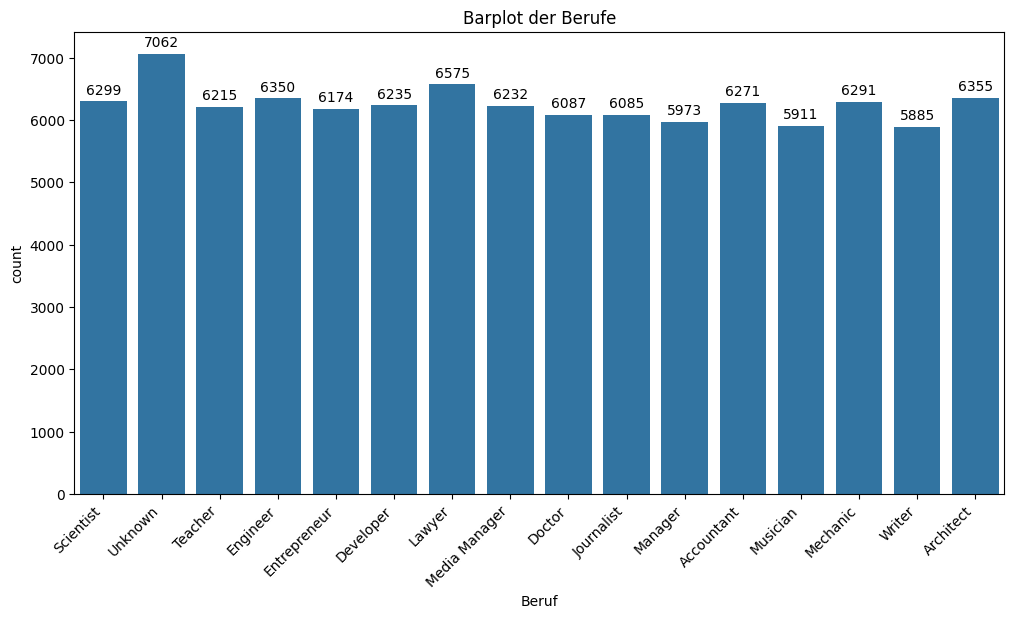

In [21]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(train_df, x="Occupation")

for container in ax.containers:
    ax.bar_label(container, fmt='%d',
                label_type='edge',
                padding=3)

plt.xticks(rotation=45, ha="right")
plt.title("Barplot der Berufe")
plt.xlabel("Beruf")
plt.show()

## Annual_Income - Represents the annual income of the person

In [22]:
train_df["Annual_Income"].isna().sum()

0

In [23]:
train_df['Annual_Income'] = (
    pd.to_numeric(
        train_df['Annual_Income']
        .astype(str)
        .str.replace(r'[^0-9\-\.]', '', regex=True)
        .replace({'': np.nan, '-': np.nan, '.': np.nan}),
        errors='coerce'
    )
    .clip(lower=0)
    .fillna(lambda s: s.median())
)

In [24]:
train_df['Annual_Income'].describe()

count    1.000000e+05
mean     1.764157e+05
std      1.429618e+06
min      7.005930e+03
25%      1.945750e+04
50%      3.757861e+04
75%      7.279092e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64

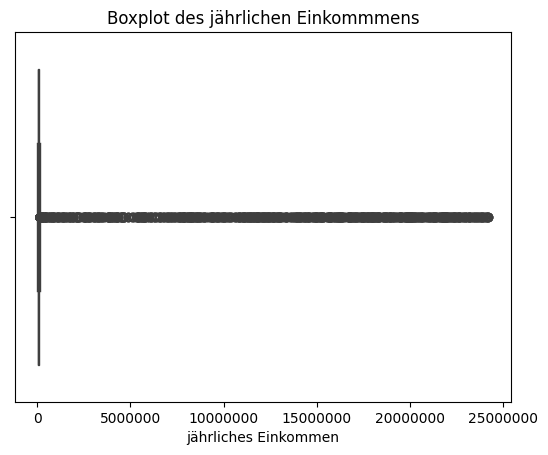

In [25]:
sns.boxplot(data=train_df, x="Annual_Income")
plt.ticklabel_format(style='plain', axis='x')
plt.title("Boxplot des jährlichen Einkommmens")
plt.xlabel("jährliches Einkommen")
plt.show()

- Sehr starke und viele Ausreißer, diese ggf. entfernen

## Monthly_Inhand_Salary - Represents the monthly base salary of a person

In [26]:
train_df['Monthly_Inhand_Salary'] = train_df['Monthly_Inhand_Salary'].fillna(train_df['Annual_Income'] / 12)

In [27]:
train_df['Monthly_Inhand_Salary'].describe()

count    1.000000e+05
mean     5.743259e+03
std      4.581469e+04
min      3.036454e+02
25%      1.625793e+03
50%      3.101372e+03
75%      5.971780e+03
max      1.990380e+06
Name: Monthly_Inhand_Salary, dtype: float64

## Num_Bank_Accounts - Represents the number of bank accounts a person holds

In [28]:
train_df['Num_Bank_Accounts'] = (
    pd.to_numeric(
        train_df['Num_Bank_Accounts']
        .astype(str)
        .str.replace(r'[^0-9\-\.]', '', regex=True)
        .replace({'': np.nan, '-': np.nan, '.': np.nan}),
        errors='coerce'
    )
    .clip(lower=0)
    .round()
    .astype('Int64')
    .fillna(lambda s: s.median())
)

In [29]:
train_df['Num_Bank_Accounts'].describe()

count      100000.0
mean       17.09149
std      117.404803
min             0.0
25%             3.0
50%             6.0
75%             7.0
max          1798.0
Name: Num_Bank_Accounts, dtype: Float64

## Num_Credit_Card - Represents the number of other credit cards held by a person

In [30]:
train_df['Num_Credit_Card'] = (
    pd.to_numeric(
        train_df['Num_Credit_Card']
        .astype(str)
        .str.replace(r'[^0-9\-\.]', '', regex=True)
        .replace({'': np.nan, '-': np.nan, '.': np.nan}),
        errors='coerce'
    )
    .clip(lower=0)
    .round()
    .astype('Int64')
    .fillna(lambda s: s.median())
)

In [31]:
train_df['Num_Credit_Card'].describe()

count     100000.0
mean      22.47443
std      129.05741
min            0.0
25%            4.0
50%            5.0
75%            7.0
max         1499.0
Name: Num_Credit_Card, dtype: Float64

## Interest_Rate - Represents the interest rate on credit card

In [32]:
train_df['Interest_Rate'] = (
    pd.to_numeric(
        train_df['Interest_Rate']
        .astype(str)
        .str.replace(r'[^0-9\-\.]', '', regex=True)
        .replace({'': np.nan, '-': np.nan, '.': np.nan}),
        errors='coerce'
    )
    .clip(lower=0)
    .round()
    .astype('Int64')
    .fillna(lambda s: s.median())
)

In [33]:
train_df['Interest_Rate'].describe()

count      100000.0
mean       72.46604
std      466.422621
min             1.0
25%             8.0
50%            13.0
75%            20.0
max          5797.0
Name: Interest_Rate, dtype: Float64

## Num_of_Loan - Represents the number of loans taken from the bank

In [34]:
train_df['Num_of_Loan'] = (
    pd.to_numeric(
        train_df['Num_of_Loan']
        .astype(str)
        .str.replace(r'[^0-9\-\.]', '', regex=True)
        .replace({'': np.nan, '-': np.nan, '.': np.nan}),
        errors='coerce'
    )
    .clip(lower=0)
    .round()
    .astype('Int64')
    .fillna(lambda s: s.median())
)

In [35]:
train_df['Num_of_Loan'].describe()

count     100000.0
mean       6.88596
std      59.150621
min            0.0
25%            1.0
50%            3.0
75%            5.0
max         1496.0
Name: Num_of_Loan, dtype: Float64

## Type_of_Loan - Represents the types of loan taken by a person

In [36]:
train_df['Type_of_Loan'] = (
    train_df['Type_of_Loan']
    .fillna('Unknown')  # Fehlende Werte
    .astype(str)
    .str.replace(' and ', ', ', regex=False)  # 'and' → Komma
    .apply(lambda x: ', '.join(                # mehrere Loan-Namen zusammenfassen
        dict.fromkeys(                        # Doppelte entfernen, Reihenfolge behalten
            part.strip().title().replace('_', ' ').replace('-', ' ')
            for part in re.split(r',\s*', x)
            if part.strip()
        )
    ) if x.strip().lower() != 'unknown' else 'Unknown')
)

In [37]:
train_df['Type_of_Loan'].head()

0    Auto Loan, Credit Builder Loan, Personal Loan,...
1    Auto Loan, Credit Builder Loan, Personal Loan,...
2    Auto Loan, Credit Builder Loan, Personal Loan,...
3    Auto Loan, Credit Builder Loan, Personal Loan,...
4    Auto Loan, Credit Builder Loan, Personal Loan,...
Name: Type_of_Loan, dtype: object

## Delay_from_due_date - Represents the average number of days delayed from the payment date

In [38]:
train_df['Delay_from_due_date'] = (
    pd.to_numeric(train_df['Delay_from_due_date'], errors='coerce')  # zu Zahlen, Fehler -> NaN
    .clip(lower=0)                                                  # keine negativen Werte
    .fillna(lambda s: s.median())                                   # fehlende durch Median ersetzen
    .astype('Int64')                                                # saubere Integer-Spalte mit NA
)

In [39]:
train_df['Delay_from_due_date'].describe()

count     100000.0
mean      21.08191
std      14.840204
min            0.0
25%           10.0
50%           18.0
75%           28.0
max           67.0
Name: Delay_from_due_date, dtype: Float64

## Num_of_Delayed_Payment - Represents the average number of payments delayed by a person

In [40]:
train_df['Num_of_Delayed_Payment'] = (
    train_df['Num_of_Delayed_Payment']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)
    .replace({'': np.nan, '-': np.nan, '.': np.nan})
    .pipe(pd.to_numeric, errors='coerce')
    .clip(lower=0)
    .pipe(lambda s: s.fillna(s.median()))   # 👈 Median korrekt in der Chain
    .astype('Int64')
)

In [41]:
train_df['Num_of_Delayed_Payment'].describe()

count      100000.0
mean       29.74903
std      218.016109
min             0.0
25%             9.0
50%            14.0
75%            18.0
max          4397.0
Name: Num_of_Delayed_Payment, dtype: Float64

## Changed_Credit_Limit - Represents the percentage change in credit card limit

In [42]:
train_df['Changed_Credit_Limit'] = (
    train_df['Changed_Credit_Limit']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)       # Nur Zahlen, Minus, Punkt behalten
    .replace({'': np.nan, '-': np.nan, '.': np.nan})  # Leere Strings / Sonderzeichen → NaN
    .pipe(pd.to_numeric, errors='coerce')             # In Zahlen umwandeln
    .fillna(0)                                        # Fehlende Werte → 0
)

In [43]:
train_df['Changed_Credit_Limit'].describe()

count    100000.000000
mean         10.171791
std           6.880628
min          -6.490000
25%           4.970000
50%           9.250000
75%          14.660000
max          36.970000
Name: Changed_Credit_Limit, dtype: float64

## Num_Credit_Inquiries - Represents the number of credit card inquiries

In [44]:
train_df['Num_Credit_Inquiries'] = (
    train_df['Num_Credit_Inquiries']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)        # Nur Zahlen, Minus, Punkt behalten
    .replace({'': np.nan, '-': np.nan, '.': np.nan})   # Leere oder symbolische Strings → NaN
    .pipe(pd.to_numeric, errors='coerce')              # In Zahl konvertieren
    .clip(lower=0)                                    # Keine negativen Werte (allow_negative=False)
    .pipe(lambda s: s.fillna(s.median()))              # Fehlende Werte mit Median ersetzen
    .round()                                           # Runden auf ganze Zahl
    .astype('Int64')                                   # Integer mit Pandas-NA-Support
)

In [45]:
train_df['Num_Credit_Inquiries'].describe()

count      100000.0
mean       27.32678
std      191.293766
min             0.0
25%             3.0
50%             6.0
75%             9.0
max          2597.0
Name: Num_Credit_Inquiries, dtype: Float64

## Credit_Mix - Represents the classification of the mix of credits

In [46]:
train_df['Credit_Mix'] = (
    train_df['Credit_Mix']
    .replace('_', 'Unknown')      # "_" ersetzen
    .fillna('Unknown')            # fehlende Werte auffüllen
    .astype(str)                  # sicherstellen, dass alles String ist
    .str.title()                  # schön formatiert (z. B. "good" → "Good")
)

In [47]:
train_df['Credit_Mix'].value_counts()

Credit_Mix
Standard    36479
Good        24337
Unknown     20195
Bad         18989
Name: count, dtype: int64

## Outstanding_Debt - Represents the remaining debt to be paid (in USD)

In [48]:
train_df['Outstanding_Debt'] = (
    train_df['Outstanding_Debt']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)       # Nur Zahlen, Minus, Punkt behalten
    .replace({'': np.nan, '-': np.nan, '.': np.nan})  # Leere Strings → NaN
    .pipe(pd.to_numeric, errors='coerce')             # Zu numerisch konvertieren
    .clip(lower=0)                                   # Keine negativen Werte
    .pipe(lambda s: s.fillna(s.median()))             # Fehlende Werte durch Median ersetzen
)

In [49]:
train_df['Outstanding_Debt'].describe()

count    100000.000000
mean       1426.220376
std        1155.129026
min           0.230000
25%         566.072500
50%        1166.155000
75%        1945.962500
max        4998.070000
Name: Outstanding_Debt, dtype: float64

## Credit_Utilization_Ratio - Represents the utilization ratio of credit card

In [50]:
train_df['Credit_Utilization_Ratio'] = (
    pd.to_numeric(train_df['Credit_Utilization_Ratio'], errors='coerce')  # In Zahlen umwandeln
    .clip(lower=0, upper=100)                                             # Begrenzen zwischen 0 und 100
    .pipe(lambda s: s.fillna(s.median()))                                 # Fehlende Werte durch Median ersetzen
)

In [51]:
train_df['Credit_Utilization_Ratio'].describe()

count    100000.000000
mean         32.285173
std           5.116875
min          20.000000
25%          28.052567
50%          32.305784
75%          36.496663
max          50.000000
Name: Credit_Utilization_Ratio, dtype: float64

## Credit_History_Age - Represents the age of credit history of the person

In [52]:
train_df['Credit_History_Age'] = (
    train_df['Credit_History_Age'].astype(str)
    .pipe(lambda s: (
        s.str.extract(r'(\d+)\s*Years', expand=False).astype(float) * 12 +
        s.str.extract(r'(\d+)\s*Months', expand=False).astype(float)
    ))
    .pipe(lambda s: s.fillna(s.median()))  # Fehlende Werte → Median
    .astype('Int64')                       # Integer mit NA-Unterstützung
)

In [53]:
train_df['Credit_History_Age'].describe()

count     100000.0
mean     220.99716
std      95.133546
min            1.0
25%          154.0
50%          219.0
75%          292.0
max          404.0
Name: Credit_History_Age, dtype: Float64

## Payment_of_Min_Amount - Represents whether only the minimum amount was paid by the person

In [54]:
train_df['Payment_of_Min_Amount'] = (
    train_df['Payment_of_Min_Amount']
    .replace('NM', 'Unknown')   # "NM" ersetzen
    .fillna('Unknown')          # fehlende Werte auffüllen
    .astype(str)                # sicherstellen, dass alles String ist
    .str.title()                # "unknown" → "Unknown", "yes" → "Yes"
)

In [55]:
train_df['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
Yes        52326
No         35667
Unknown    12007
Name: count, dtype: int64

## Total_EMI_per_month - Represents the monthly EMI payments (in USD)

In [56]:
train_df['Total_EMI_per_month'] = (
    train_df['Total_EMI_per_month']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)       # Nur Zahlen, Minus, Punkt behalten
    .replace({'': np.nan, '-': np.nan, '.': np.nan})  # Leere oder symbolische Strings -> NaN
    .pipe(pd.to_numeric, errors='coerce')             # In Zahlen umwandeln
    .clip(lower=0)                                   # Keine negativen Werte (allow_negative=False)
    .pipe(lambda s: s.fillna(s.median()))             # Fehlende Werte durch Median ersetzen
)

In [57]:
train_df['Total_EMI_per_month'].describe()

count    100000.000000
mean       1403.118217
std        8306.041270
min           0.000000
25%          30.306660
50%          69.249473
75%         161.224249
max       82331.000000
Name: Total_EMI_per_month, dtype: float64

## Amount_invested_monthly - Represents the monthly amount invested by the customer (in USD)

In [58]:
train_df['Amount_invested_monthly'] = (
    train_df['Amount_invested_monthly']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)       # Nur Ziffern, Minus und Punkt behalten
    .replace({'': np.nan, '-': np.nan, '.': np.nan})  # Leere oder Platzhalter → NaN
    .pipe(pd.to_numeric, errors='coerce')             # In numerisch konvertieren
    .clip(lower=0)                                   # Negative Werte auf 0 setzen
    .pipe(lambda s: s.fillna(s.median()))             # Fehlende Werte mit Median auffüllen
)

In [59]:
train_df['Amount_invested_monthly'].describe()

count    100000.000000
mean        614.951381
std        1999.726647
min           0.000000
25%          77.017414
50%         135.925682
75%         255.038698
max       10000.000000
Name: Amount_invested_monthly, dtype: float64

## Payment_Behaviour - Represents the payment behavior of the customer (in USD)

In [60]:
train_df['Payment_Behaviour'] = (
    train_df['Payment_Behaviour']
    .replace('!@9#%8', 'Unknown')     # Sonderwert ersetzen
    .fillna('Unknown')                # Fehlende Werte auffüllen
    .astype(str)                      # Sicherstellen, dass alles String ist
    .str.replace('_', ' ', regex=False)  # Unterstriche durch Leerzeichen ersetzen
    .str.replace(r'\s+', ' ', regex=True) # Mehrere Leerzeichen zu einem
    .str.strip()                      # Leerzeichen am Anfang/Ende entfernen
    .str.title()                      # Schön formatieren ("low_spender" → "Low Spender")
)

In [61]:
train_df['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low Spent Small Value Payments      25513
High Spent Medium Value Payments    17540
Low Spent Medium Value Payments     13861
High Spent Large Value Payments     13721
High Spent Small Value Payments     11340
Low Spent Large Value Payments      10425
Unknown                              7600
Name: count, dtype: int64

## Monthly_Balance - Represents the monthly balance amount of the customer (in USD)

In [62]:
train_df['Monthly_Balance'] = (
    train_df['Monthly_Balance']
    .astype(str)
    .str.replace(r'[^0-9\-\.]', '', regex=True)       # Nur Ziffern, Minus, Punkt behalten
    .replace({'': np.nan, '-': np.nan, '.': np.nan})  # Leere Strings oder Sonderzeichen → NaN
    .pipe(pd.to_numeric, errors='coerce')             # In numerisch umwandeln
    .where(lambda s: s > -1e6, other=np.nan)          # Unrealistische Werte (zu negativ) entfernen
    .pipe(lambda s: s.fillna(s.median()))             # Fehlende Werte mit Median ersetzen
)

In [63]:
train_df['Monthly_Balance'].describe()

count    100000.000000
mean        401.755494
std         212.750017
min           0.007760
25%         270.913865
50%         336.731225
75%         467.670597
max        1602.040519
Name: Monthly_Balance, dtype: float64

## Credit_Score - Represents the bracket of credit score (Poor, Standard, Good)

In [64]:
train_df['Credit_Score'] = train_df['Credit_Score'].str.title()

In [65]:
train_df['Credit_Score'].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

### Qualitätscheck nach der Bereinigung


In [66]:
train_df.isna().sum()
train_df.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                           Int64
SSN                          object
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             Int64
Num_Credit_Card               Int64
Interest_Rate                 Int64
Num_of_Loan                   Int64
Type_of_Loan                 object
Delay_from_due_date           Int64
Num_of_Delayed_Payment        Int64
Changed_Credit_Limit        float64
Num_Credit_Inquiries          Int64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age            Int64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                

# 2️⃣ Datenbereinigung - test

## Hilfsfunktion aus train

Die vorgenommenen Bereinigungsschritte aus train werden für test angewendet (außer für Credit_Score)

In [67]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Wendet die train-Bereinigung auf eine Kopie von df an."""
    cleaned = df.copy()

    ssn_placeholders = {'#F%$D@*&8'}
    ssn_pattern = re.compile(r'^\d{3}-\d{2}-\d{4}$')

    def _strip_identifier(column_name):
        if column_name in cleaned.columns:
            cleaned[column_name] = cleaned[column_name].astype(str).str.strip()

    def _numeric_from_string(column_name, clip_lower=None, clip_upper=None, fill='median', as_int=False):
        if column_name not in cleaned.columns:
            return
        series = (
            cleaned[column_name]
            .astype(str)
            .str.replace(r'[^0-9\-\.]', '', regex=True)
            .replace({'': np.nan, '-': np.nan, '.': np.nan, 'nan': np.nan, 'None': np.nan})
        )
        numeric = pd.to_numeric(series, errors='coerce')
        if clip_lower is not None:
            numeric = numeric.clip(lower=clip_lower)
        if clip_upper is not None:
            numeric = numeric.clip(upper=clip_upper)
        if fill == 'median':
            fill_value = numeric.median()
            if pd.isna(fill_value):
                fill_value = 0
            numeric = numeric.fillna(fill_value)
        elif fill is not None:
            numeric = numeric.fillna(fill)
        if as_int:
            numeric = numeric.round().astype('Int64')
        cleaned[column_name] = numeric

    for column in ('ID', 'Customer_ID'):
        _strip_identifier(column)

    if 'Name' in cleaned.columns:
        name = (
            cleaned['Name']
            .fillna('Unknown')
            .astype(str)
            .str.strip()
            .str.replace(r"\s+", ' ', regex=True)
            .str.title()
        )
        cleaned['Name'] = name

    if 'SSN' in cleaned.columns:
        ssn = cleaned['SSN'].astype('string').str.strip()
        ssn = ssn.where(~ssn.isin(ssn_placeholders), other=pd.NA)
        ssn = ssn.where(ssn.str.fullmatch(ssn_pattern), other=pd.NA)
        cleaned['SSN'] = ssn

    if 'Month' in cleaned.columns:
        cleaned['Month'] = (
            cleaned['Month']
            .astype('string')
            .str.strip()
            .str.title()
        )

    if 'Age' in cleaned.columns:
        age = cleaned['Age'].astype('string').str.replace('_', '', regex=False)
        age = pd.to_numeric(age, errors='coerce').abs()
        mask = age >= 100
        age.loc[mask] = age.loc[mask].astype(str).str[:2].astype(float)
        mask = age >= 100
        age.loc[mask] = age.loc[mask].astype(str).str[:1].astype(float)
        age = age.clip(lower=18, upper=90)
        median_age = age.median()
        if pd.isna(median_age):
            median_age = 30
        age = age.fillna(median_age)
        cleaned['Age'] = age.round().astype('Int64')

    if 'Occupation' in cleaned.columns:
        occupation = cleaned['Occupation'].astype('string').replace('_______', 'Unknown')
        occupation = occupation.fillna('Unknown')
        occupation = (
            occupation
            .str.replace('_', ' ', regex=False)
            .str.replace(r"\s+", ' ', regex=True)
            .str.strip()
            .str.title()
        )
        cleaned['Occupation'] = occupation

    _numeric_from_string('Annual_Income', clip_lower=0)

    if 'Monthly_Inhand_Salary' in cleaned.columns and 'Annual_Income' in cleaned.columns:
        monthly = pd.to_numeric(cleaned['Monthly_Inhand_Salary'], errors='coerce')
        monthly = monthly.fillna(cleaned['Annual_Income'] / 12)
        cleaned['Monthly_Inhand_Salary'] = monthly

    for column in ('Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan'):
        _numeric_from_string(column, clip_lower=0, as_int=True)

    if 'Type_of_Loan' in cleaned.columns:
        def _format_loans(value):
            if not isinstance(value, str):
                return 'Unknown'
            value = value.strip()
            if not value or value.lower() in {'unknown', 'nan'}:
                return 'Unknown'
            normalized = value.replace(' and ', ', ')
            parts = [
                part.strip().title().replace('_', ' ').replace('-', ' ')
                for part in re.split(r',\s*', normalized)
                if part.strip()
            ]
            return ', '.join(dict.fromkeys(parts)) or 'Unknown'

        cleaned['Type_of_Loan'] = cleaned['Type_of_Loan'].astype(str).apply(_format_loans)

    _numeric_from_string('Delay_from_due_date', clip_lower=0, as_int=True)

    if 'Num_of_Delayed_Payment' in cleaned.columns:
        delayed = (
            cleaned['Num_of_Delayed_Payment']
            .astype(str)
            .str.replace(r'[^0-9\-\.]', '', regex=True)
            .replace({'': np.nan, '-': np.nan, '.': np.nan, 'nan': np.nan, 'None': np.nan})
            .pipe(pd.to_numeric, errors='coerce')
            .clip(lower=0)
        )
        fill_value = delayed.median()
        if pd.isna(fill_value):
            fill_value = 0
        delayed = delayed.fillna(fill_value).round().astype('Int64')
        cleaned['Num_of_Delayed_Payment'] = delayed

    _numeric_from_string('Changed_Credit_Limit', fill=0)
    _numeric_from_string('Num_Credit_Inquiries', clip_lower=0, as_int=True)

    if 'Credit_Mix' in cleaned.columns:
        mix = cleaned['Credit_Mix'].replace('_', 'Unknown').fillna('Unknown').astype(str)
        cleaned['Credit_Mix'] = mix.str.title()

    _numeric_from_string('Outstanding_Debt', clip_lower=0)
    _numeric_from_string('Credit_Utilization_Ratio', clip_lower=0, clip_upper=100)

    if 'Credit_History_Age' in cleaned.columns:
        history = cleaned['Credit_History_Age'].astype('string')
        years = pd.to_numeric(history.str.extract(r'(\d+)\s*Years', expand=False), errors='coerce').fillna(0)
        months = pd.to_numeric(history.str.extract(r'(\d+)\s*Months', expand=False), errors='coerce').fillna(0)
        total_months = years * 12 + months
        total_months = total_months.where(total_months > 0, other=np.nan)
        median_history = total_months.median()
        if pd.isna(median_history):
            median_history = 0
        cleaned['Credit_History_Age'] = total_months.fillna(median_history).round().astype('Int64')

    if 'Payment_of_Min_Amount' in cleaned.columns:
        payment_min = cleaned['Payment_of_Min_Amount'].replace('NM', 'Unknown')
        payment_min = payment_min.fillna('Unknown').astype(str)
        cleaned['Payment_of_Min_Amount'] = payment_min.str.title()

    for column in ('Total_EMI_per_month', 'Amount_invested_monthly'):
        _numeric_from_string(column, clip_lower=0)

    if 'Payment_Behaviour' in cleaned.columns:
        behaviour = (
            cleaned['Payment_Behaviour']
            .replace('!@9#%8', 'Unknown')
            .fillna('Unknown')
            .astype(str)
            .str.replace('_', ' ', regex=False)
            .str.replace(r"\s+", ' ', regex=True)
            .str.strip()
            .str.title()
        )
        cleaned['Payment_Behaviour'] = behaviour

    if 'Monthly_Balance' in cleaned.columns:
        balance = (
            cleaned['Monthly_Balance']
            .astype(str)
            .str.replace(r'[^0-9\-\.]', '', regex=True)
            .replace({'': np.nan, '-': np.nan, '.': np.nan, 'nan': np.nan, 'None': np.nan})
            .pipe(pd.to_numeric, errors='coerce')
        )
        balance = balance.where(balance > -1e6, other=np.nan)
        median_balance = balance.median()
        if pd.isna(median_balance):
            median_balance = 0
        cleaned['Monthly_Balance'] = balance.fillna(median_balance)

    if 'Credit_Score' in cleaned.columns:
        cleaned['Credit_Score'] = cleaned['Credit_Score'].astype(str).str.title()

    return cleaned

## Überprüfung

In [68]:
test_df = clean_dataframe(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  string 
 3   Name                      50000 non-null  object 
 4   Age                       50000 non-null  Int64  
 5   SSN                       47172 non-null  string 
 6   Occupation                50000 non-null  string 
 7   Annual_Income             50000 non-null  float64
 8   Monthly_Inhand_Salary     50000 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  Int64  
 10  Num_Credit_Card           50000 non-null  Int64  
 11  Interest_Rate             50000 non-null  Int64  
 12  Num_of_Loan               50000 non-null  Int64  
 13  Type_of_Loan              50000 non-null  object 
 14  Delay_

# 3️⃣ Export

In [69]:
train_df.to_csv("../data/train_cleaned.csv")
test_df.to_csv("../data/test_cleaned.csv")